# Goal of This Notebook

The primary objective of this notebook is to analyze customer reviews of Amazon Alexa products and develop a sentiment classification model. The classification task will focus on categorizing reviews into distinct sentiment classes based on the feedback provided.

# Install required modules

In [24]:
!pip install kagglehub --quiet
!pip install vaderSentiment --quiet

In [25]:
import kagglehub
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Exploratory Data Analysis

##### Load dataset from kaggle

In [26]:
path = Path(kagglehub.dataset_download("sid321axn/amazon-alexa-reviews"))
path = Path(path)

df = pd.read_csv(path / "amazon_alexa.tsv", sep="\t")
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


##### Handle null values

In [27]:
null_values = df.isnull().sum()
print(null_values)

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


As the only missing feature in one row is `verified_reviews` and it is not possible (or reasonable) to fill or estimate this value, I decided to drop the row containing the missing value.

In [28]:
df = df.dropna()
null_values = df.isnull().sum()
print(null_values)

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64


##### Relationship Between Feedback and Rating

The dataset contains both `feedback` and `rating` features. Understanding their relationship can provide insights into customer satisfaction and sentiment. Grouping and analyzing these features together can reveal patterns, such as whether higher ratings consistently correspond to positive feedback.

In [29]:
grouped_df = df.groupby(['rating', 'feedback'])
grouped_df.size()

rating  feedback
1       0            161
2       0             95
3       1            152
4       1            455
5       1           2286
dtype: int64

##### Insights on Feedback and Ratings

From the analysis, it is evident that reviews with a rating of 2 or below consistently have feedback labeled as 0 (negative), while ratings above 2 always correspond to feedback labeled as 1 (positive). This observation simplifies the task of classifying opinions into feedback categories: 0 (negative) or 1 (positive). The next steps will involve leveraging this relationship to develop a classification model for sentiment analysis.

##### Distribution of ratings in dataset

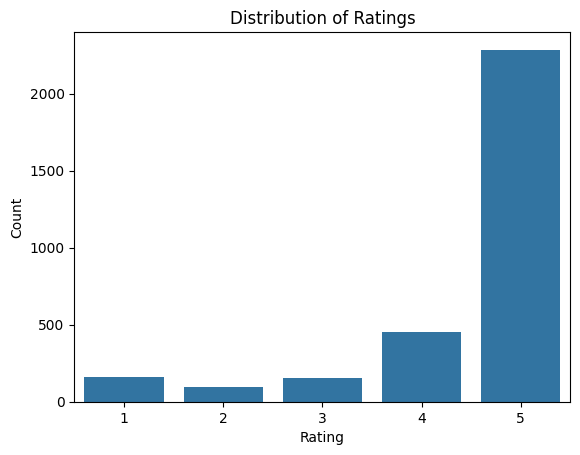

In [30]:
sns.countplot(data=df, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

##### Conclusion on Rating Distribution

The plot shows that the majority of ratings are highly positive, with a significant number of 5-star reviews. I won't draw plot of feedback distribution but its easy to deduce that there are a lot less objects with feedback 0 than feedback 1.

#### Evaluation of other features

##### Variation

In [41]:
feedback_0_percentage = (
    df[df['feedback'] == 0]
    .groupby('variation')
    .size() / df.groupby('variation').size() * 100
).reset_index(name='feedback_0_percentage')

variation_counts = df.groupby('variation').size().reset_index(name='count')
feedback_0_percentage = feedback_0_percentage.merge(variation_counts, on='variation')

print(feedback_0_percentage.sort_values(by='feedback_0_percentage', ascending=False))

                       variation  feedback_0_percentage  count
11                         White              17.777778     90
0                          Black              13.409962    261
4                    Black  Spot              13.278008    241
14                   White  Show              12.941176     85
15                   White  Spot              11.009174    109
2                    Black  Plus              10.370370    270
13                   White  Plus              10.256410     78
6   Configuration: Fire TV Stick               8.000000    350
1                     Black  Dot               6.976744    516
3                    Black  Show               6.792453    265
9              Sandstone Fabric                6.666667     90
12                    White  Dot               6.521739    184
5               Charcoal Fabric                2.790698    430
7           Heather Gray Fabric                1.273885    157
8                    Oak Finish                     NaN

Although there are some differences in feedback based on variation, I have decided not to pursue this further. This is because new variations of Alexa may be introduced in the future, which could reduce the robustness of the model.

##### Date

No reason for date to be relevant for sentiment classification.

#### Dropping Irrelevant Columns

For the sentiment analysis task, columns such as `date` and `variation` may not significantly contribute to predicting sentiment. Having said that, only the verified_reviews feature will be considered in next steps. 


In [ ]:
reviews_df = df[['feedback', 'verified_reviews', 'rating']]
reviews_df.head()

,feedback,verified_reviews,rating
0,1,Love my Echo!,5
1,1,Loved it!,5
2,1,"Sometimes while playing a game, you can answer...",4
3,1,I have had a lot of fun with this thing. My 4 ...,5
4,1,Music,5


# Checking performance of Vader (Valence Aware Dictionary and sEntiment Reasoner)

In [ ]:
reviews_df.loc[:, 'vader_sentiment'] = reviews_df['verified_reviews'].apply(
    lambda review: analyzer.polarity_scores(review)['compound']
)

reviews_df[['verified_reviews', 'vader_sentiment', 'feedback']].head()


,verified_reviews,vader_sentiment,feedback
0,Love my Echo!,0.6696,1
1,Loved it!,0.6360,1
2,"Sometimes while playing a game, you can answer...",-0.1280,1
3,I have had a lot of fun with this thing. My 4 ...,0.9169,1
4,Music,0.0000,1


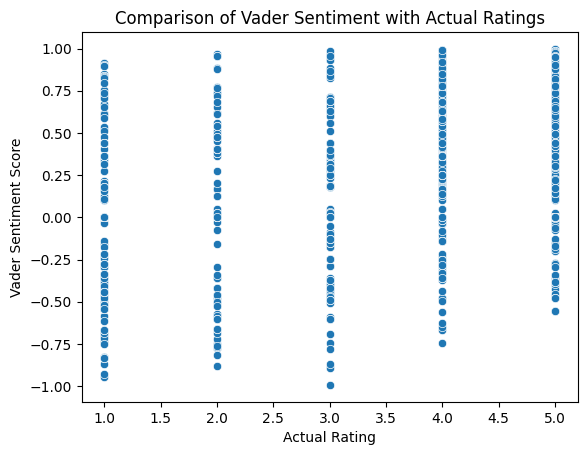

In [ ]:
sns.scatterplot(data=reviews_df, x='rating', y='vader_sentiment')
plt.title('Comparison of Vader Sentiment with Actual Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Vader Sentiment Score')
plt.show()

In [ ]:
def classify_sentiment(score, pos_threshold=0.1, neg_threshold=-0.1):
    if score >= pos_threshold:
        return 1
    return 0
    
reviews_df['predicted_feedback'] = reviews_df['vader_sentiment'].apply(
    lambda score: classify_sentiment(score, pos_threshold=0.2, neg_threshold=-0.2)
)

reviews_df[['verified_reviews', 'vader_sentiment', 'adjusted_sentiment']].head()

,verified_reviews,vader_sentiment,adjusted_sentiment
0,Love my Echo!,0.6696,Positive
1,Loved it!,0.6360,Positive
2,"Sometimes while playing a game, you can answer...",-0.1280,Neutral
3,I have had a lot of fun with this thing. My 4 ...,0.9169,Positive
4,Music,0.0000,Neutral
